In [1]:
%pip install rake_nltk

Note: you may need to restart the kernel to use updated packages.


In [305]:
import pandas as pd
df = pd.read_csv('../IMDB/IMDB_Top250Engmovies2_OMDB_Detailed.csv')
df.head(1)

,Unnamed: 0,Title,Year,Rated,Released,Runtime,Genre,Director,Writer,Actors,...,tomatoConsensus,tomatoUserMeter,tomatoUserRating,tomatoUserReviews,tomatoURL,DVD,BoxOffice,Production,Website,Response
0,1,The Shawshank Redemption,1994,R,14 Oct 1994,142 min,"Crime, Drama",Frank Darabont,"Stephen King (short story ""Rita Hayworth and S...","Tim Robbins, Morgan Freeman, Bob Gunton, Willi...",...,NaN,NaN,NaN,NaN,http://www.rottentomatoes.com/m/shawshank_rede...,27 Jan 1998,NaN,Columbia Pictures,NaN,True


In [306]:
# to remove punctuations from Plot

from rake_nltk import Rake

# 移除標點符號
df['Plot'] = df['Plot'].str.replace('[^ws]','')
Plot = df["Plot"]
df['Key_words'] = ''   # initializing a new column
r = Rake()   # using Rake to remove stop words

for index, row in df.iterrows():
    r.extract_keywords_from_text(row['Plot'])
    key_words_dict_scores = r.get_word_degrees()
    df.at[index, 'Key_words'] = list(key_words_dict_scores.keys())

print(df['Key_words'])

0      [two, imprisoned, men, bond, number, years, fi...
1      [aging, patriarch, organized, crime, dynasty, ...
2      [early, life, career, vito, corleone, 1920s, n...
3      [menace, known, joker, emerges, mysterious, pa...
4      [jury, holdout, attempts, prevent, miscarriage...
                             ...                        
245    [desperate, life, chronic, alcoholic, followed...
246    [20, something, supervising, staff, member, re...
247    [newspaper, editor, uses, every, trick, book, ...
248    [old, man, makes, long, journey, lawn, mover, ...
249    [mumbai, teen, reflects, upbringing, slums, ac...
Name: Key_words, Length: 250, dtype: object


In [331]:


df['Genre_lower'] = df['Genre'].apply(lambda x: [i.strip().lower() for i in x.split(',')])
df['Actors_lower'] = df['Actors'].apply(lambda x: [i.strip().lower() for i in x.split(',')][:3])
df['Director_lower'] = df['Director'].apply(lambda x: [i.strip().lower() for i in x.split(',')])
df['Year_str'] = df['Year'].astype(str)

# 檢查是否正確應用了變更
print(df[['Genre_lower', 'Actors_lower', 'Director_lower', 'Year_str']].head(3))

      Genre_lower                               Actors_lower  \
0  [crime, drama]  [tim robbins, morgan freeman, bob gunton]   
1  [crime, drama]     [marlon brando, al pacino, james caan]   
2  [crime, drama]   [al pacino, robert duvall, diane keaton]   

           Director_lower Year_str  
0        [frank darabont]     1994  
1  [francis ford coppola]     1972  
2  [francis ford coppola]     1974  


In [119]:

from gensim.models import KeyedVectors

word2vec_model = KeyedVectors.load_word2vec_format('../model/GoogleNews-vectors-negative300.bin.gz', binary=True)

https://link.springer.com/chapter/10.1007/978-3-540-85836-2_29

論文參考

https://blog.csdn.net/weixin_44151089/article/details/104959249

網站參考


In [310]:
import pandas as pd
import re
from sentence_transformers import SentenceTransformer, util
from scipy.stats import spearmanr
import numpy as np

# 加载预训练的 SentenceTransformer 模型
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# 定义函数处理文本：去除标点符号和转换为小写
def clean_text(text):
    return re.sub(r'[^\w\s]', '', text.lower())

# 读取数据

# 清理并转换 'Key_words2' 列中的文本

df['Key_words_joined'] = df['Key_words'].apply(lambda x: ' '.join(x))
print(df['Key_words_joined'].head(1))
df['Key_words_joined'] = df['Key_words_joined'].apply(clean_text)

# 获取每个句子的嵌入向量
embeddings = model.encode(df['Key_words_joined'].tolist(), convert_to_tensor=True)

# 创建存储相似度矩阵
cosine_sim_matrix = np.zeros((len(embeddings), len(embeddings)))

# 计算每对句子的余弦相似度
for i in range(len(embeddings)):
    for j in range(len(embeddings)):
        cosine_sim_matrix[i, j] = util.pytorch_cos_sim(embeddings[i], embeddings[j]).item()

# 保存相似度矩阵到文件
np.savetxt("sentence_transformers_cosine_similarity_matrix.txt", cosine_sim_matrix, fmt="%f")

# 打印前几行进行检查
print(cosine_sim_matrix[:5, :5])

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


0    two imprisoned men bond number years finding s...
Name: Key_words_joined, dtype: object
[[1.         0.26608935 0.13785848 0.14567845 0.18288586]
 [0.26608935 1.00000012 0.39777046 0.14579472 0.03968604]
 [0.13785848 0.39777046 1.00000012 0.24266261 0.02539758]
 [0.14567845 0.14579472 0.24266261 1.         0.09679182]
 [0.18288586 0.03968604 0.02539758 0.09679182 1.00000012]]


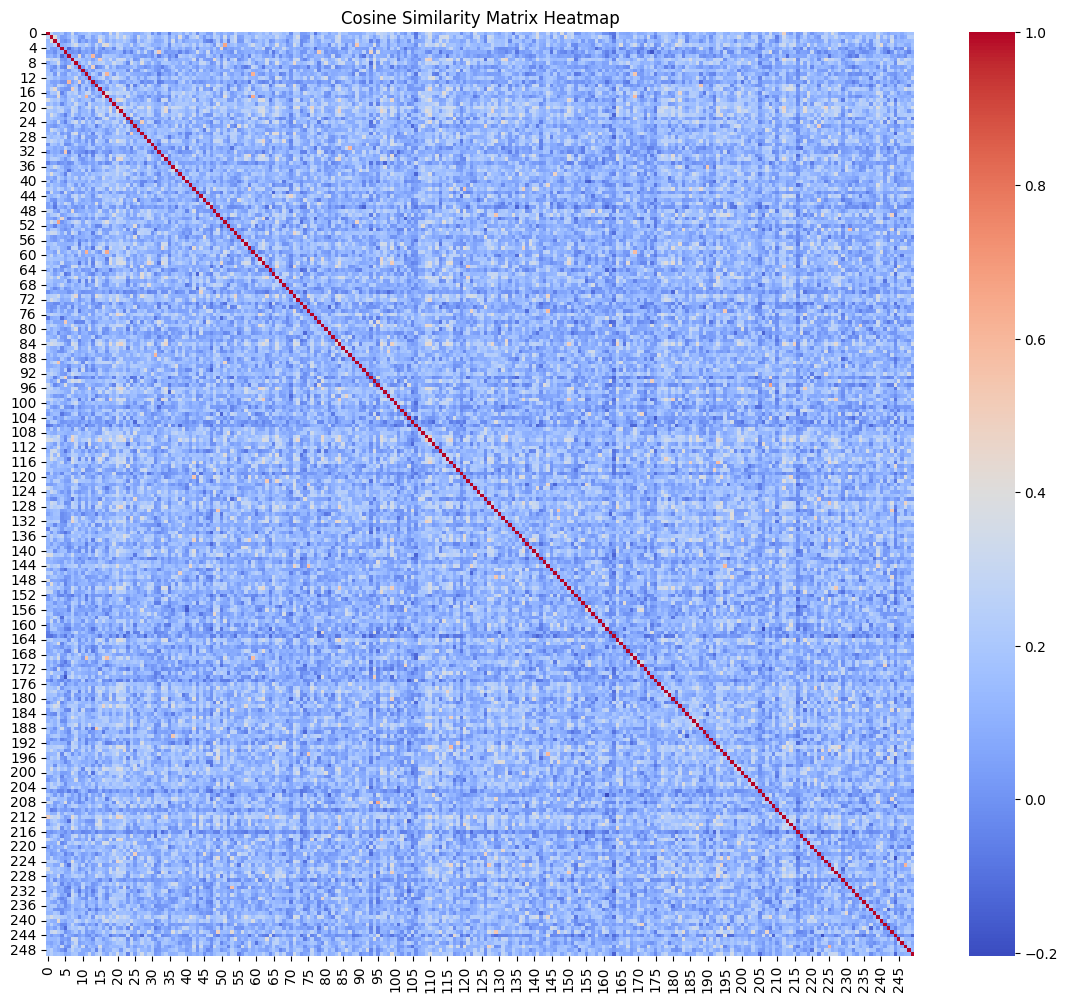

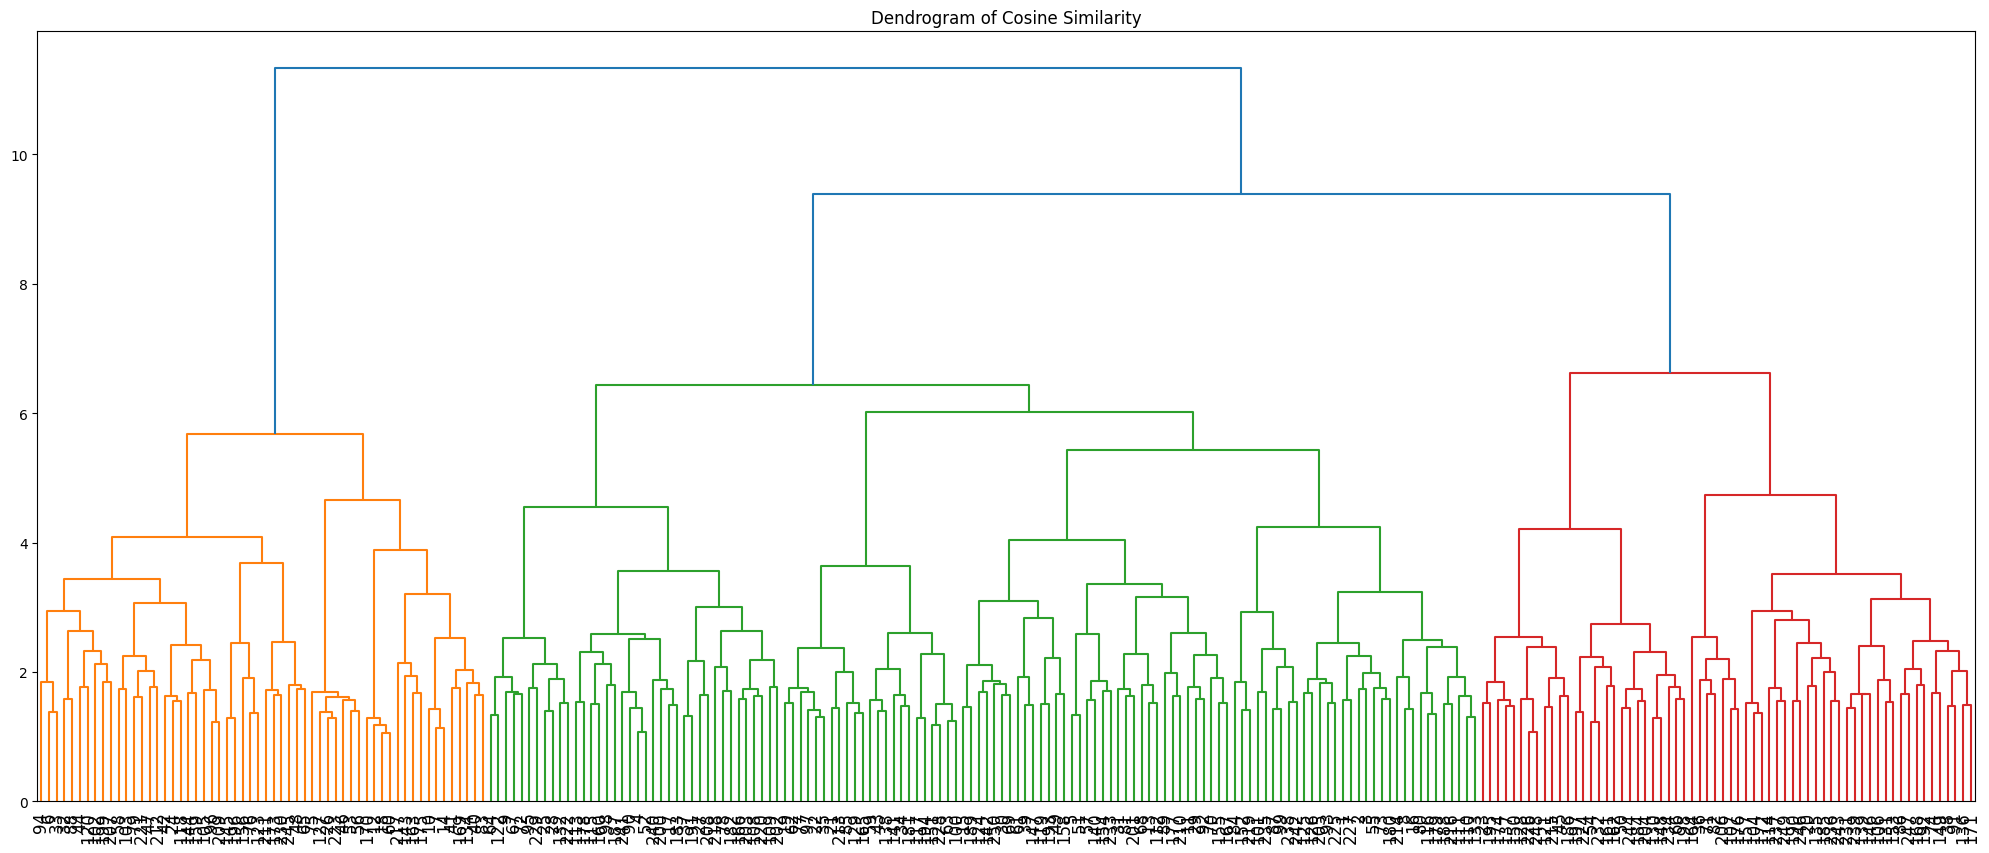

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics.pairwise import cosine_similarity



# 使用 Seaborn 绘制热力图
plt.figure(figsize=(14, 12))
sns.heatmap(cosine_sim_matrix, cmap='coolwarm')
plt.title("Cosine Similarity Matrix Heatmap")
plt.show()

# 使用 SciPy 进行层次聚类，并绘制树状图
linked = linkage(cosine_sim_matrix, 'ward')  # 使用最小距离方法

# 确保标签数量正确
num_docs = cosine_sim_matrix.shape[0]
labels = [f"{i+1}" for i in range(num_docs)]

plt.figure(figsize=(25, 10))
dendrogram(linked, labels=labels, leaf_rotation=90, leaf_font_size=12,color_threshold=linked[-(3-1), 2] )
plt.title("Dendrogram of Cosine Similarity")
plt.show()


c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\

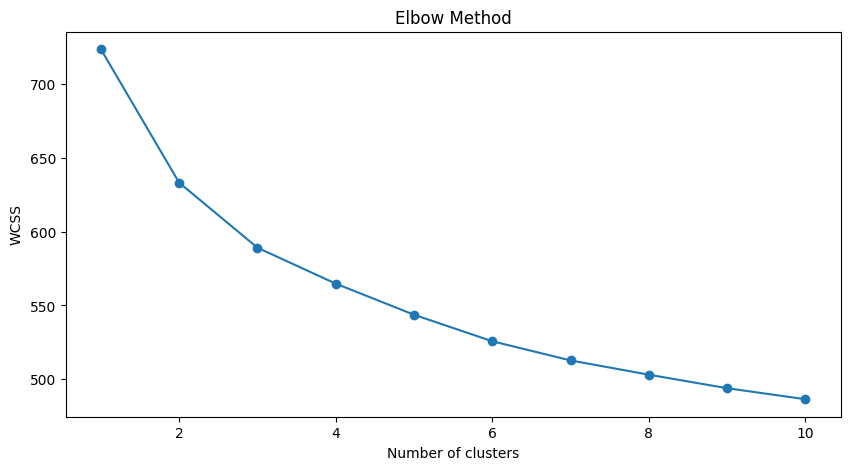

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\

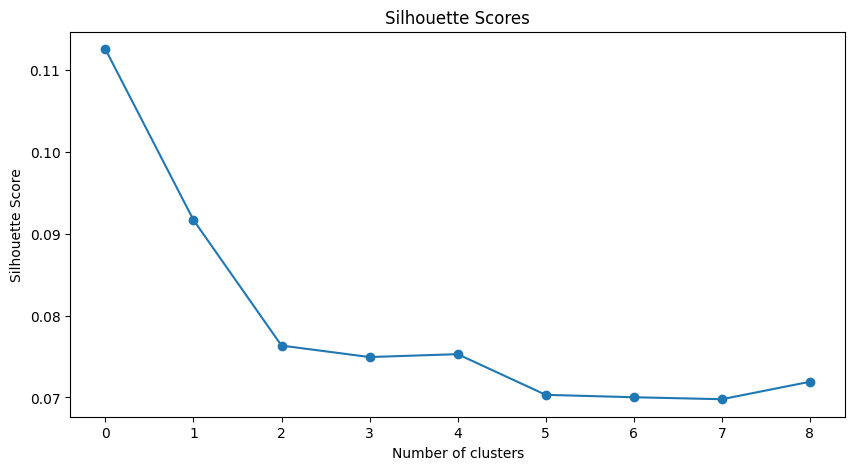

In [8]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# 生成一些樣本數據
np.random.seed(42)
data = np.random.rand(100, 2)

# 肘部法則
wcss = []
max_clusters = 10
for i in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(cosine_sim_matrix)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(range(1, max_clusters + 1), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# 輪廓係數
silhouette_scores = []
for i in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=i, random_state=42)
    cluster_labels = kmeans.fit_predict(cosine_sim_matrix)
    silhouette_avg = silhouette_score(cosine_sim_matrix, cluster_labels)
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(10, 5))
plt.plot(silhouette_scores, marker='o')
plt.title('Silhouette Scores')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [9]:
indices = pd.Series(df['Title'])

In [10]:
def recommend(title, cosine_sim = cosine_sim_matrix):
    recommended_movies = []
    idx = indices[indices == title].index[0]   # to get the index of the movie title matching the input movie
    score_series = pd.Series(cosine_sim[idx]).sort_values(ascending = False)   # similarity scores in descending order
    top_5_indices = list(score_series.iloc[1:6].index)   # to get the indices of top 6 most similar movies
    # [1:6] to exclude 0 (index 0 is the input movie itself)
    
    print(cosine_sim)
    print()
    # print(cosine_sim_1)
    
    for i in top_5_indices:   # to append the titles of top 10 similar movies to the recommended_movies list
        recommended_movies.append([list(df['Title'])[i],score_series[i],list(df['Genre'])[i]])
        
    return recommended_movies

# 打印结果
setience = recommend('The Maltese Falcon')
result = df[df['Title'] == 'The Maltese Falcon'][['Title','Genre','Director','Actors','Plot']]
result.to_csv("data.txt",index=False)
print(result)
print()
for i in  (setience):
    print(i)

[[1.         0.26608935 0.13785848 ... 0.14430316 0.18540296 0.1816102 ]
 [0.26608935 1.00000012 0.39777046 ... 0.09205152 0.24853504 0.24184524]
 [0.13785848 0.39777046 1.00000012 ... 0.15086286 0.12878883 0.16080017]
 ...
 [0.14430316 0.09205152 0.15086286 ... 1.         0.18603949 0.12074175]
 [0.18540296 0.24853504 0.12878883 ... 0.18603949 1.00000012 0.13788246]
 [0.1816102  0.24184524 0.16080017 ... 0.12074175 0.13788246 1.        ]]

                  Title               Genre     Director  \
150  The Maltese Falcon  Film-Noir, Mystery  John Huston   

                                                Actors  \
150  Humphrey Bogart, Mary Astor, Gladys George, Pe...   

                                                  Plot  
150  A private detective takes on a case that invol...  

['The Big Sleep', 0.5224451422691345, 'Crime, Film-Noir, Mystery']
['Chinatown', 0.5020266175270081, 'Drama, Mystery, Thriller']
['L.A. Confidential', 0.49836108088493347, 'Crime, Drama, Mystery']
['Dou

In [314]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# 計算詞向量的相似度
def vector_similarity(word, model):
    return model[word] if word in model else np.zeros(model.vector_size)

# 計算搜索詞與其他詞的最大相似度
def calculate_max_similarity(search_term, words, model):
    search_terms = search_term.split()
    search_vectors = [vector_similarity(term, model) for term in search_terms]
    
    word_vectors = [vector_similarity(word, model) for word in words]
    
    # 計算每個詞與每個搜索詞的相似度並取最大值
    max_similarity = 0
    for search_vector in search_vectors:
        word_similarities = [cosine_similarity([search_vector], [vec])[0][0] for vec in word_vectors]
        max_similarity = max(max_similarity, np.max(word_similarities))
    
    return max_similarity

# 根據類型推薦相似的電影類型
def recommend_similar_genres(type_name, input_genre, df, model):
    type_names = type_name + 's'
    df[type_names] = df[type_name].apply(lambda x: ''.join(x))
    genres = df[type_names].tolist()
    
    # 計算輸入類型與所有類型的相似度
    similarities = []
    for g in genres:
        words = g.split()
        max_similarity = calculate_max_similarity(input_genre, words, model)
        similarities.append(max_similarity)

    # 排序並獲取前三個最相似的類型
    sorted_indices = np.argsort(similarities)[::-1][:3]
    recommended_genres = set()
    recommended_genre_indices = []

    for idx in sorted_indices:
        current_genre = genres[idx]
        if current_genre not in recommended_genres :
            recommended_genres.add(current_genre)
            recommended_genre_indices.append(idx)

    recommended_movies = []
    for idx in recommended_genre_indices:
        genre = genres[idx]
        print(f"'{input_genre}' 與 '{genre}' 最相似。 相似度分數: {similarities[idx]}")
        
        # 找到屬於這個類型的所有電影
        matching_indices = [i for i, g in enumerate(genres) if g == genre]
        for idx in matching_indices:
            recommended_movies.append([df['Title'][idx], df['Director'][idx], df['Actors'][idx], df['Genre'][idx], df['Plot'][idx]])
    return recommended_movies

a = recommend_similar_genres('Actors','Gerry Robert Byrne', df, word2vec_model)
for movie in a:
    print(f"电影名称: {movie[0]}, 導演: {movie[1]}  演員: {movie[2]}  类型: {movie[3]}, 剧情简介: {movie[4]}")

'Gerry Robert Byrne' 與 'Marlon Brando, Martin Sheen, Robert Duvall, Frederic Forrest' 最相似。 相似度分數: 1.0000001192092896
'Gerry Robert Byrne' 與 'Robin Williams, Robert Sean Leonard, Ethan Hawke, Josh Charles' 最相似。 相似度分數: 1.0000001192092896
'Gerry Robert Byrne' 與 'Robert De Niro, John Cazale, John Savage, Christopher Walken' 最相似。 相似度分數: 1.0000001192092896
电影名称: Apocalypse Now, 導演: Francis Ford Coppola  演員: Marlon Brando, Martin Sheen, Robert Duvall, Frederic Forrest  类型: Drama, War, 剧情简介: During the Vietnam War, Captain Willard is sent on a dangerous mission into Cambodia to assassinate a renegade colonel who has set himself up as a god among a local tribe.
电影名称: Dead Poets Society, 導演: Peter Weir  演員: Robin Williams, Robert Sean Leonard, Ethan Hawke, Josh Charles  类型: Comedy, Drama, 剧情简介: English teacher John Keating inspires his students to look at poetry with a different perspective of authentic knowledge and feelings.
电影名称: The Deer Hunter, 導演: Michael Cimino  演員: Robert De Niro, John C

In [315]:
import pickle

def load_crf_model(file_path):
    with open(file_path, 'rb') as file:
        model = pickle.load(file)
    print(f"Model loaded from {file_path}")
    return model

# 從檔案載入您的CRF模型
crf = load_crf_model('crf_ner_model.pkl')

Model loaded from crf_ner_model.pkl


[('What', 'O'), ('2008', 'B-Year'), ('crime', 'B-Genre'), ('movie', 'O'), ('directed', 'O'), ('by', 'O'), ('Eli', 'B-Director'), ('Roth', 'I-Director'), ('features', 'O'), ('Ellen', 'B-Actor'), ('Burstyn', 'I-Actor'), ('and', 'O'), ('De', 'B-Actor'), ('Niro', 'I-Actor'), ('in', 'O'), ('leading', 'O'), ('roles', 'O')]
('What', 'O')
('2008', 'B-Year')
('crime', 'B-Genre')
('movie', 'O')
('directed', 'O')
('by', 'O')
('Eli', 'B-Director')
('Roth', 'I-Director')
('features', 'O')
('Ellen', 'B-Actor')
('Burstyn', 'I-Actor')
('and', 'O')
('De', 'B-Actor')
('Niro', 'I-Actor')
('in', 'O')
('leading', 'O')
('roles', 'O')


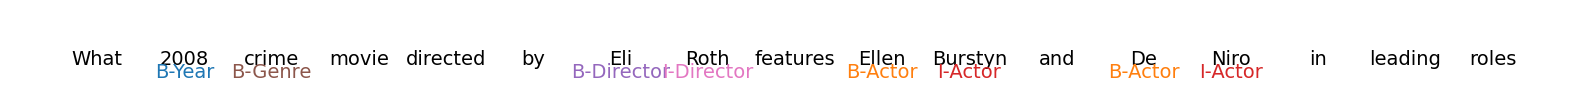

In [385]:


import pandas as pd
from sklearn.model_selection import train_test_split
import sklearn_crfsuite
from sklearn_crfsuite import metrics
from sklearn.metrics import classification_report
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score

def extract_features(sentence):
    tokens = sentence.split()
    features_list = []
    
    for i in range(len(tokens)):
        word = tokens[i]
        features = {
            'bias': 1.0,
            'word.lower()': word.lower(),
            'word[-3:]': word[-3:],
            'word[-2:]': word[-2:],
            'word.isupper()': word.isupper(),
            'word.istitle()': word.istitle(),
            'word.isdigit()': word.isdigit(),
        }
        if i > 0:
            word1 = tokens[i-1]
            features.update({
                '-1:word.lower()': word1.lower(),
                '-1:word.istitle()': word1.istitle(),
                '-1:word.isupper()': word1.isupper(),
            })
        else:
            features['BOS'] = True
        
        if i < len(tokens) - 1:
            word1 = tokens[i+1]
            features.update({
                '+1:word.lower()': word1.lower(),
                '+1:word.istitle()': word1.istitle(),
                '+1:word.isupper()': word1.isupper(),
            })
        else:
            features['EOS'] = True
        
        features_list.append(features)
    
    return [features_list]

def predict(sentence, crf_model):
    features = extract_features(sentence)
    labels = crf_model.predict(features)
    return list(zip(sentence.split(), labels[0]))

# 使用您的句子進行預測
sentence = "What 2008 crime movie directed by Eli Roth features Ellen Burstyn and De Niro in leading roles?"
sentence = re.sub(r'[^\w\s]', '', sentence)
predicted_labels = predict(sentence, crf)
print(predicted_labels)


for i in predicted_labels:
    print(i)

import matplotlib.pyplot as plt
from matplotlib.patches import Patch


def visualize_ner(sent, labels):
    words, tags = zip(*labels)
    unique_tags = list(set(tags))
    # 給每個標籤分配顏色，標籤'O'使用淺灰色，其他使用較鮮豔的顏色
    tag2color = {tag: f"C{i}" if tag != 'O' else "#dddddd" for i, tag in enumerate(unique_tags)}

    plt.figure(figsize=(16, 1))  # 調整畫布大小
    ax = plt.gca()
    
    # 計算單詞之間的間距
    space_between_words = 1
    x_positions = [i * space_between_words for i in range(len(words))]
    
    for i, (word, tag) in enumerate(zip(words, tags)):
        ax.text(x_positions[i], 0, word, color="black", fontsize=14, ha="center", va="bottom")
        # 僅當標籤不是'O'時才顯示顏色標籤
        if tag != 'O':
            ax.text(x_positions[i], 0.1, tag, color=tag2color[tag], fontsize=14, ha="center", va="top")
    
    ax.axis("off")
    ax.set_xlim([0 - space_between_words, x_positions[-1] + space_between_words])  # 調整x軸範圍以更好地適應文字
    plt.tight_layout()  # 這會自動調整子圖參數，以給定的填充適應畫布大小
    plt.show()

# 使用更新的可視化函數
visualize_ner(sentence, predicted_labels)

In [386]:
for i in predicted_labels:
    print(i)

print("=======================")
non_o_labels = [(word, label) for word, label in predicted_labels if label != 'O']

for word, label in non_o_labels:
    print(f"({word}, {label})")

('What', 'O')
('2008', 'B-Year')
('crime', 'B-Genre')
('movie', 'O')
('directed', 'O')
('by', 'O')
('Eli', 'B-Director')
('Roth', 'I-Director')
('features', 'O')
('Ellen', 'B-Actor')
('Burstyn', 'I-Actor')
('and', 'O')
('De', 'B-Actor')
('Niro', 'I-Actor')
('in', 'O')
('leading', 'O')
('roles', 'O')
(2008, B-Year)
(crime, B-Genre)
(Eli, B-Director)
(Roth, I-Director)
(Ellen, B-Actor)
(Burstyn, I-Actor)
(De, B-Actor)
(Niro, I-Actor)


In [387]:
def extract_entities(predicted_labels, entity_type):
    entities = []
    current_entity = []
    
    for word, label in predicted_labels:
        if label == f"B-{entity_type}":
            if current_entity:
                entities.append(" ".join(current_entity))
                current_entity = []
            current_entity.append(word)
        elif label == f"I-{entity_type}" and current_entity:
            current_entity.append(word)
        elif label == "O" and current_entity:
            entities.append(" ".join(current_entity))
            current_entity = []
    
    if current_entity:
        entities.append(" ".join(current_entity))
    
    return entities

actors = extract_entities(predicted_labels, "Actor")
directors = extract_entities(predicted_labels, "Director")
years = extract_entities(predicted_labels, "Year")
genres = extract_entities(predicted_labels, "Genre")

print("Actors:")
search_word = []
for actor in actors:
    print(f"Actor: {actor}")
    search_word.append(['Actor',actor])

print("\nDirector:")
for director in directors:
    print(f"Director: {director}")
    search_word.append(['Director',directors])

print("\nYears:")
for year in years:
    print(f"Year: {year}")
    search_word.append(['Year',year])

print("\nGenres:")
for genre in genres:
    print(f"Genre: {genre}")
    search_word.append(['Genre',genre])
print("============")
search_word = []
for actor in actors:
    print(f"Actor: {actor}")
    search_word.append(['Actors', actor])

print("\nDirectors:")
for director in directors:
    print(f"Director: {director}")
    search_word.append(['Director', director])

print("\nYears:")
for year in years:
    print(f"Year: {year}")
    search_word.append(['Year', year])

print("\nGenres:")
for genre in genres:
    print(f"Genre: {genre}")
    search_word.append(['Genre', genre])


Actors:
Actor: Ellen Burstyn
Actor: De Niro

Director:
Director: Eli Roth

Years:
Year: 2008

Genres:
Genre: crime
Actor: Ellen Burstyn
Actor: De Niro

Directors:
Director: Eli Roth

Years:
Year: 2008

Genres:
Genre: crime


In [388]:
def recommend(title, cosine_sim = cosine_sim_matrix):
    recommended_movies = []
    idx = indices[indices == title].index[0]   # to get the index of the movie title matching the input movie
    score_series = pd.Series(cosine_sim[idx]).sort_values(ascending = False)   # similarity scores in descending order
    top_5_indices = list(score_series.iloc[1:6].index)   # to get the indices of top 6 most similar movies
    # [1:6] to exclude 0 (index 0 is the input movie itself)
  
    # print(cosine_sim_1)
    
    for i in top_5_indices:   # to append the titles of top 10 similar movies to the recommended_movies list
        recommended_movies.append([list(df['Title'])[i],score_series[i],list(df['Genre'])[i]])
        
    return recommended_movies

# 打印结果
setience = recommend('The Maltese Falcon')
result = df[df['Title'] == 'The Maltese Falcon'][['Title','Genre','Director','Actors','Plot']]
result.to_csv("data.txt",index=False)
print(result)
print()
for i in  (setience):
    print(i)

                  Title               Genre     Director  \
150  The Maltese Falcon  Film-Noir, Mystery  John Huston   

                                                Actors  \
150  Humphrey Bogart, Mary Astor, Gladys George, Pe...   

                                                  Plot  
150  A private detective takes on a case that invol...  

['The Big Sleep', 0.5224451422691345, 'Crime, Film-Noir, Mystery']
['Chinatown', 0.5020266175270081, 'Drama, Mystery, Thriller']
['L.A. Confidential', 0.49836108088493347, 'Crime, Drama, Mystery']
['Double Indemnity', 0.4483705759048462, 'Crime, Drama, Film-Noir']
['Se7en', 0.4396160840988159, 'Crime, Drama, Mystery']


In [389]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd

def vector_similarity_kinds(word, model):
    return model[word] if word in model else np.zeros(model.vector_size)

def calculate_max_similarity_kinds(search_term, words, model):
    search_terms = search_term.split()
    search_vectors = [vector_similarity_kinds(term, model) for term in search_terms]
    word_vectors = [vector_similarity_kinds(word, model) for word in words]

    max_similarity = 0
    for search_vector in search_vectors:
        if np.linalg.norm(search_vector) == 0:
            continue
        for word_vector in word_vectors:
            if np.linalg.norm(word_vector) == 0:
                continue
            similarity = cosine_similarity([search_vector], [word_vector])[0][0]
            max_similarity = max(max_similarity, similarity)
    
    return max_similarity

def recommend_similar_kinds(type_name, input_kind, df, model):
    type_names = type_name + 's'
    df[type_names] = df[type_name].apply(lambda x: ''.join(x))
    kinds = df[type_names].tolist()
    
    similarities = []
    for k in kinds:
        words = k.split()
        max_similarity = calculate_max_similarity_kinds(input_kind, words, model)
        similarities.append(max_similarity)

    sorted_indices = np.argsort(similarities)[::-1]
    recommended_kinds = set()
    recommended_kind_indices = []
    
    for idx in sorted_indices:
        current_kind = kinds[idx]
        if len(recommended_kind_indices) < 3 or similarities[idx] == 1:
            if current_kind not in recommended_kinds:
                recommended_kinds.add(current_kind)
                recommended_kind_indices.append(idx)

    recommended_movies = []
    for idx in recommended_kind_indices:
        kind = kinds[idx]
        print(f"'{input_kind}' 與 '{kind}' 最相似。 相似度分數: {similarities[idx]:.2f}")
        
        matching_indices = [i for i, k in enumerate(kinds) if k == kind]
        for idx in matching_indices:
            recommended_movies.append([df['Title'][idx], df['Directors'][idx], df['Actors'][idx], df['Genre'][idx], df['Plot'][idx]])
    return recommended_movies


In [390]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd

def vector_similarity(word, model):
    return model[word] if word in model else np.zeros(model.vector_size)

def calculate_max_similarity(search_term, words, model):
    search_terms = search_term.split()
    search_vectors = [vector_similarity(term, model) for term in search_terms]
    word_vectors = [vector_similarity(word, model) for word in words]

    max_similarity = 0
    for search_vector in search_vectors:
        if np.linalg.norm(search_vector) == 0:
            continue
        for vec in word_vectors:
            if np.linalg.norm(vec) == 0:
                continue
            similarity = cosine_similarity([search_vector], [vec])[0][0]
            max_similarity = max(max_similarity, similarity)
    
    return max_similarity

def recommend_similar_genres(type_name, input_genre, df, model):
    if type_name == "Year":
        type_name = "Year_str"
        recommended_movies = df[df[type_name] == input_genre][['Title', 'Directors', 'Actors', 'Genre', 'Year_str', 'Plot']]
        recommended_movies_list = recommended_movies.values.tolist()
        
        if not recommended_movies_list:
            print(f"没有此年份电影 {input_genre}")
            return []
        print(f"有此年份電影 {input_genre}")
        return recommended_movies_list

    # type_name = type_name + '_lower'
    type_names = type_name + '_s'
    df[type_names] = df['Genre_lower'].apply(lambda x: ' '.join(x))
    print(df[type_names].head(3))
    genres = df[type_names].tolist()
    genres_name =  df[type_name].tolist()
    
    similarities = []
    for g in genres:
        words = g.split()
        max_similarity = calculate_max_similarity(input_genre, words, model)
        similarities.append(max_similarity)

    sorted_indices = np.argsort(similarities)[::-1]
    recommended_genres = set()
    recommended_genre_indices = []
    max_similarity = similarities[sorted_indices[0]]

    for idx in sorted_indices:
        if len(recommended_genre_indices) < 3 or similarities[idx] == 1:
            current_genre = genres[idx]
            if current_genre not in recommended_genres and current_genre != input_genre:
                recommended_genres.add(current_genre)
                recommended_genre_indices.append(idx)

    recommended_movies = []
    for idx in recommended_genre_indices:
        genre = genres[idx]
        print(f"'{input_genre}' 與 '{genre}' 最相似。 相似度分數: {similarities[idx]:.2f}")
        
        matching_indices = [i for i, g in enumerate(genres) if g == genre]
        for idx in matching_indices:
            recommended_movies.append([df['Title'][idx], df['Directors'][idx], df['Actors'][idx], df['Genre'][idx], df['Year_str'][idx], df['Plot'][idx]])

    return recommended_movies

def handle_search(type_name, word):
    print("type = ",type_name,",word = ",word)
    if type_name == "Actors" or type_name == "Director":
        
        a = recommend_similar_kinds(type_name, word, df, word2vec_model)
        for movie in a:
            print(f"电影名称: {movie[0]}, 导演: {movie[1]}  演员: {movie[2]}  类型: {movie[3]},年份: {movie[4]}")
        print("================================")
        
        return
        
    a = recommend_similar_genres(type_name, word, df, word2vec_model)
    for movie in a:
        print(f"电影名称: {movie[0]}, 导演: {movie[1]}  演员: {movie[2]}  类型: {movie[3]},年份: {movie[4]}")
    print("================================")

# print(df['Genre_lower'])
for type_name, word in search_word:
    handle_search(type_name, word)


type =  Actors ,word =  Ellen Burstyn
'Ellen Burstyn' 與 'Ellen Burstyn, Jared Leto, Jennifer Connelly, Marlon Wayans' 最相似。 相似度分數: 1.00
'Ellen Burstyn' 與 'Albert Brooks, Ellen DeGeneres, Alexander Gould, Willem Dafoe' 最相似。 相似度分數: 1.00
'Ellen Burstyn' 與 'Ellen Burstyn, Max von Sydow, Lee J. Cobb, Kitty Winn' 最相似。 相似度分數: 1.00
电影名称: Requiem for a Dream, 导演: Darren Aronofsky  演员: Ellen Burstyn, Jared Leto, Jennifer Connelly, Marlon Wayans  类型: Drama,年份: The drug-induced utopias of four Coney Island people are shattered when their addictions run deep.
电影名称: Finding Nemo, 导演: Andrew Stanton, Lee Unkrich  演员: Albert Brooks, Ellen DeGeneres, Alexander Gould, Willem Dafoe  类型: Animation, Adventure, Comedy,年份: After his son is captured in the Great Barrier Reef and taken to Sydney, a timid clownfish sets out on a journey to bring him home.
电影名称: The Exorcist, 导演: William Friedkin  演员: Ellen Burstyn, Max von Sydow, Lee J. Cobb, Kitty Winn  类型: Horror,年份: When a teenage girl is possessed by a myste